# Prediction of dontation using Decision Tree

In this notebook, we will study the method of using Decision tree classification to classify the source of the donation

#### Abstract

The Governement of Andhra Pradesh is planning on constructing a new capital city, Amaravati after the partition of the erstwhile state of Andhra Pradesh, into Telengana and Andhra Pradesh. For this enterprise, the Govt has asked for people to donate amount, as per their requirement. The Govt would convert the donated money into "bricks", that would be used in this enterprise

Each of the bricks is worth 10 rupees of the amount dontated.

#### **Dataset Source**

The source of the dataset is from the website: [amaravati.gov.in](https://amaravati.gov.in/EBRICKS/UserInterface/reports/PartnerDetailsRDLReportnew.aspx). From the URL we can select the start date and end date for the report, and the mode of the payment.

So, for our requirements, the start date is from 01-Jan-2016, till 11-Mar-2017, and the mode of payment was chosen to be "Meseva"

We'll now look into the data set.

(Note: The dataset was obtained in the form of an `.xlsx` file format, we have converted it into `.csv` format, as it is easier to work with.)

In [1]:
import pandas as pd

In [2]:
orig_data = pd.read_csv('initial_data_5k.csv')

Now, let us look a into a few samples of the data

In [3]:
orig_data.head(5)

,S.No,Reference No,Partner Name,No Of Bricks,Total Amount,Payment Date,Partner Type,Country Name,State Name,City Name,Amount Credited to Andhra Bank (Pay ID),Date Credited
0,1,EBRCM011500002238,N SIVA SANKAR,1,10,10/23/2015 5:46:21 PM,Individual,India,Andhra Pradesh,NANDYAL,NaN,NaN
1,2,EBRCM011500002248,GAYATHRI,5,50,10/23/2015 5:46:21 PM,Individual,India,Andhra Pradesh,NELLORE,NaN,NaN
2,3,EBRCM011500002267,BALE RAVISHOBAN KUMAR,11,110,10/23/2015 5:46:21 PM,Individual,India,Andhra Pradesh,ELURU,NaN,NaN
3,4,EBRCM011500002280,KORADA UMARANI,6,60,10/23/2015 5:46:21 PM,Family,India,Andhra Pradesh,PARVATHIPURAM,NaN,NaN
4,5,EBRCM011500002281,A RANI,1,10,10/23/2015 5:46:22 PM,Individual,India,Andhra Pradesh,GUNTUR,NaN,NaN


The total number of rows of the dataset:

In [4]:
len(orig_data['Partner Name '])

5409

#### Problem Statement

So, now that we have seen the dataset, let us obtain a problem statement

One problem that we can try to solve from the data set is, given a date and amount, can we predict where the dontation has come from ?

First, let see how many unique sources of donation are there:

In [5]:
set(orig_data['Partner Type'])

{'Family', 'Friend', 'Individual', 'Organization'}

Now, we know that, there are 4 unique sources from where the donation can come from. Now, for a rough idea, we can see which type have donated the most

In [6]:
from collections import Counter

Counter(orig_data['Partner Type'])

Counter({'Family': 441, 'Friend': 35, 'Individual': 4832, 'Organization': 101})

#### Data Preprocessing 

Now, This data set contains more than required data, and so we will take only the columns that we need, such as the date column and the bricks count column (we could take with bricks column or amount column, since 1 brick = 10 rupees)

(Before we move further, we would have to convert the date from `DD/MM/YYYY HH:MM:SS AM|PM` format to a simple `YYYY-MM` format, since we only need the months and years, the time is extra information that be removed. This change was made in the excel, and then saved as `.csv` file

In [7]:
date_data = pd.read_csv('original_data_5k.csv')

In [8]:
date_data.head(5)

,S.No,Reference No,Partner Name,No Of Bricks,Total Amount,Payment Date,Partner Type,Country Name,State Name,City Name,Amount Credited to Andhra Bank (Pay ID),Date Credited
0,1,EBRCM011500002238,N SIVA SANKAR,1,10,2015-10,Individual,India,Andhra Pradesh,NANDYAL,NaN,NaN
1,2,EBRCM011500002248,GAYATHRI,5,50,2015-10,Individual,India,Andhra Pradesh,NELLORE,NaN,NaN
2,3,EBRCM011500002267,BALE RAVISHOBAN KUMAR,11,110,2015-10,Individual,India,Andhra Pradesh,ELURU,NaN,NaN
3,4,EBRCM011500002280,KORADA UMARANI,6,60,2015-10,Family,India,Andhra Pradesh,PARVATHIPURAM,NaN,NaN
4,5,EBRCM011500002281,A RANI,1,10,2015-10,Individual,India,Andhra Pradesh,GUNTUR,NaN,NaN


Now, we will split the date into years and months separately

In [9]:
date_data['Payment Date'].head(5)

0    2015-10
1    2015-10
2    2015-10
3    2015-10
4    2015-10
Name: Payment Date, dtype: object

In [11]:
months = []
for month in list(date_data['Payment Date']):
    months.append(int(month.split('-')[1]))

In [12]:
years = []
for year in list(date_data['Payment Date']):
    years.append(int(year.split('-')[0]))

Now, We will have to also convert the `Partner Type` option into numerical data, from string data

In [13]:
partner_type = []
for pt in list(date_data['Partner Type']):
    if pt == 'Individual':
        partner_type.append(int(1))
    elif pt == 'Family':
        partner_type.append(int(2))
    elif pt == 'Friend':
        partner_type.append(int(3))
    elif pt == 'Organization':
        partner_type.append(int(4))

Now, we can verify the counts to see if all the counts of converted values, match the counts of the original values

In [14]:
len(date_data['Payment Date'])

5409

In [15]:
len(months)

5409

In [16]:
len(years)

5409

In [17]:
Counter(date_data['Partner Type'])

Counter({'Family': 441, 'Friend': 35, 'Individual': 4832, 'Organization': 101})

In [18]:
Counter(partner_type)

# 1 --> Individual
# 2 --> Family
# 3 --> Friend
# 4 --> Organisation

Counter({1: 4832, 2: 441, 3: 35, 4: 101})

Now, all the converted data matches, so now we can create a new dataset using only the required columns.

In [19]:
created_data = {
    'bricks_count' : list(date_data['No Of Bricks']),
    'year' : years,
    'month' : months,
    'partner' : partner_type,
    'partner_verbose' : list(date_data['Partner Type'])
}

In [20]:
# ndf = New Data Frame
ndf = pd.DataFrame(created_data, columns=['bricks_count', 'year', 'month', 'partner', 'partner_verbose'])

In [21]:
ndf

,bricks_count,year,month,partner,partner_verbose
0,1,2015,10,1,Individual
1,5,2015,10,1,Individual
2,11,2015,10,1,Individual
3,6,2015,10,2,Family
4,1,2015,10,1,Individual
5,5,2015,10,2,Family
6,2,2015,10,1,Individual
7,116,2015,10,1,Individual
8,1,2015,10,1,Individual
9,1,2015,10,1,Individual


Now, We'll save it into a csv file, and save it.

In [22]:
ndf.to_csv('cleaned_data.csv')

Now, we will load up this dataset and use that

In [23]:
data = pd.read_csv('cleaned_data.csv')

In [24]:
data.head(5)

,Unnamed: 0,bricks_count,year,month,partner,partner_verbose
0,0,1,2015,10,1,Individual
1,1,5,2015,10,1,Individual
2,2,11,2015,10,1,Individual
3,3,6,2015,10,2,Family
4,4,1,2015,10,1,Individual


Here we create the X and Y lists; X consists of  `bricks_count, year, month` which is the features set, and Y consists of the `partner`, which is the class label  

In [25]:
X = data.values[:, 1:4]

In [26]:
Y = data.values[:, 4]

Now, we have the data set ready, so we will split the data

In [27]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.4, random_state = 100)

/home/pratheek/msc/pythons/lib64/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The `train_test_split` function takes the two parameters `X` and `Y` which are our features set and the class label respectively.

The `test_size=0.4` paramter is used to select how many number of rows is being used to create the testing data. 0.4 indicates we want to use 40% of the total date size

The `random_state=100`, this is the random number that is used to randomize the data when picking the size for 40% of the data

#### Analysis

Now, we have all the data ready, the only thing remaining is to create the decision tree and fit the data

In [28]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, list(y_train))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Now, the tree had been trained and fitted with the training data set. Let us try and predict one class label, we'll try to predict the first class label

In [29]:
clf.predict([[1, 2015, 10]])

array([1])

The model has predicted that, when bricks_count is 1, year is 2015, and month is 10, the predicted partner type is 1, which is of Individual type

So, our prediction has come out with 100% accuracy, this was expected as we gave it a trained value. Now, we can test with the testing values.

In [30]:
ypred = clf.predict(X_test)

ypred

array([1, 1, 1, ..., 1, 1, 1])

Now we have the predicted class labels. Let us measure the accuracy of the tested values with the predicted values

For this we need to import the `accuracy_score` function from the metrics module of sklearn package

In [31]:
from sklearn.metrics import accuracy_score

now, we can calculate the accuracy score, its two parameters being the testing values and the pedicted values.

In [32]:
ascore = accuracy_score(list(y_test), list(ypred)) * (100)

print("Accuracy Score: {}".format(ascore))

Accuracy Score: 89.64879852125694


Thus we see that, our decision tree has the accuracy score of 89% which is sufficient to classify this model as a fitting model.

Now, we can generate the Decision tree Graph

In [33]:
from IPython.display import Image
import pydotplus

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=data.bricks_count,  
                         class_names=data.partner_verbose,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 

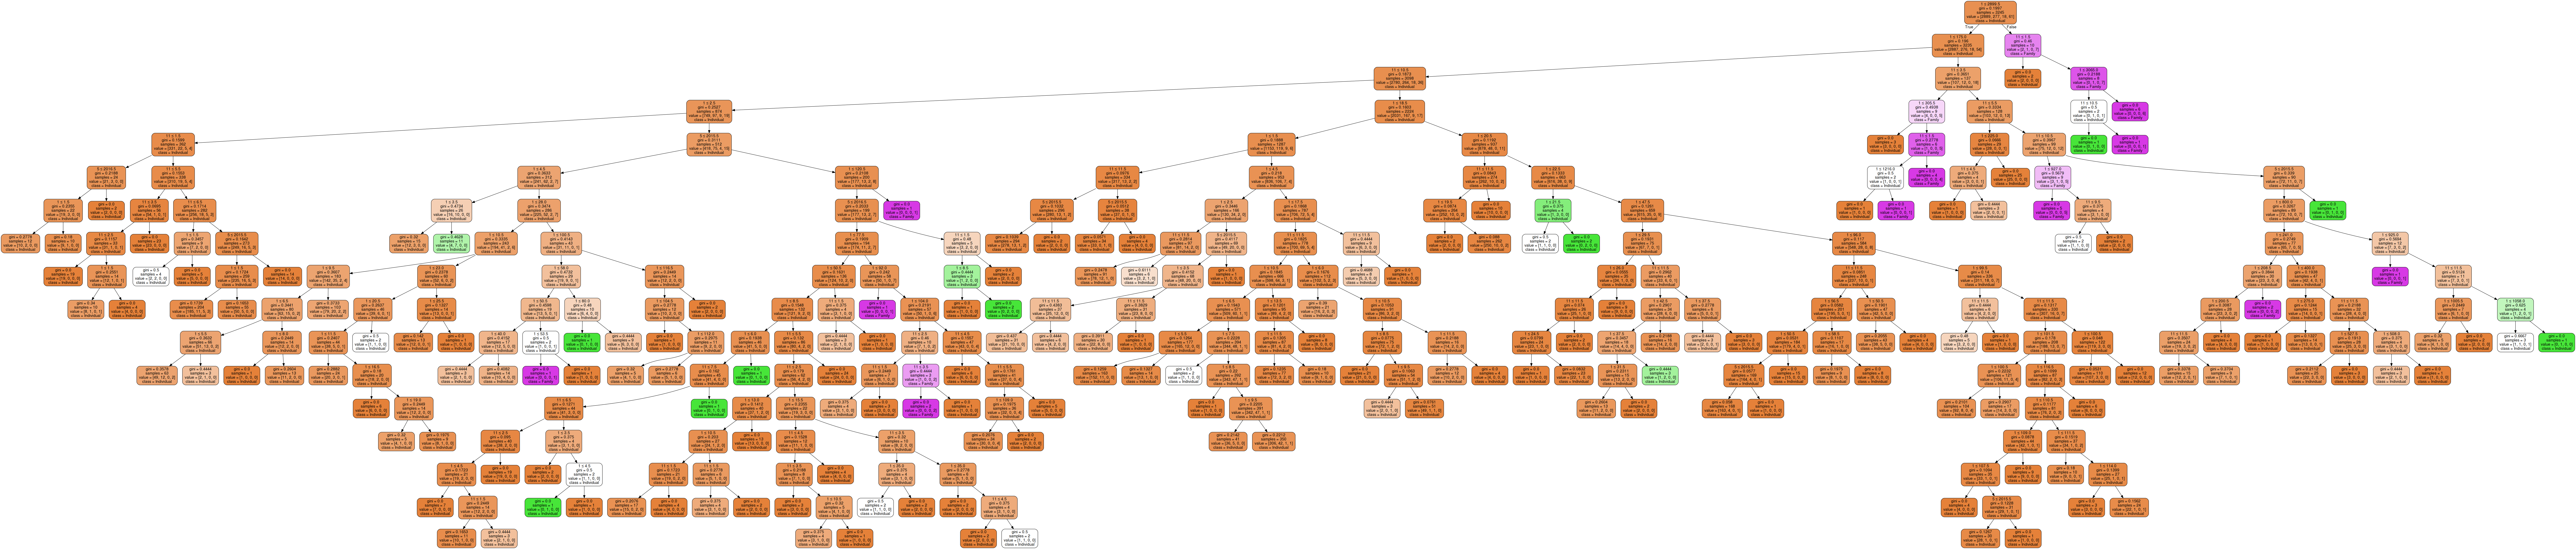

In [34]:
# Double click on the image to zoom
Image(graph.create_png(), retina=True)

#### Inference

From this model we can infer with certain amount of certainity that, given a brick_count, year, and month we can say which type of partner has donated.

This inference is useful as the Govt of AP can use this to classify from which type of partner, most of the donation would be recieved from.

With more analysis, we can even use the time values, to classify, during which time of the day more number of donations would be recieved, and appropriately, the servers can be tuned to handle those loads